In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

import analyze2p.decoding as dec

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'
# ----------------------------------------

In [4]:
%matplotlib notebook

In [5]:
experiment = 'blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ----------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()
# CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
#                 if not meta.query('@va == visual_area and @dk == datakey').empty])
# # Neural data
# NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
#                       response_type=response_type, trial_epoch=trial_epoch,
#                       responsive_test=responsive_test, 
#                       responsive_thr=responsive_thr)
# if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
#     NDATA0['experiment'] = experiment 

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [6]:
C_value=1.0
test_split=0.2
cv_nfolds=5

chance_level = 1/8. if experiment=='gratings' else 0.5

In [21]:
analysis_type='by_ncells'
test_type='size_single'
class_name = 'morphlevel'
match_rfs = False
overlap_thr= 0.0 #0.0
greater_than=True


overlap_str = 'greaterthan' if greater_than else ''
test_str = 'default' if test_type is None else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, '%s' % test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print(basedir)

## Output dirs

In [8]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
if overlap_thr is not None and isinstance(overlap_thr, (list, np.ndarray)) or match_rfs:
    curr_dst_dir = os.path.join(basedir, 'controls')
else:
    curr_dst_dir = os.path.join(basedir, aggr_id)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)
print(aggr_id)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'generalization')

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00
dff-ROC__stimulus__overlap0.00__C1.00


## Load

In [9]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [81]:
experiment = 'gratings' if class_name=='ori' else 'blobs'
iterdf, missing_ = dec.load_iterdf(meta, class_name,
                          experiment=experiment,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr)
if match_rfs and (responsive_test=='ROC'):
    iterdf = iterdf[iterdf.n_cells<=96]

(Li) Found 14 paths
(Lm) Found 14 paths
(V1) Found 15 paths


In [82]:
itershuff, missing_shuff = dec.load_iterdf(meta, class_name,
                          experiment=experiment,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr,
                          shuffle_visual_area=True)

(Li) Found 12 paths
(Lm) Found 12 paths
(V1) Found 12 paths


In [83]:
itershuff['n_cells'].unique()

array([  1,   2,   4,   8,  16,  96,  32,  64, 128, 141,  94, 120])

In [84]:
grouper = ['visual_area', 'condition', 'iteration']
mean_df0 = dec.average_within_iterations_by_ncells(iterdf, 
                            analysis_type=analysis_type, test_type=test_type,
                            grouper=grouper) 

if test_type is not None:
    score_table = mean_df0[ (mean_df0.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells', 'novel'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=['visual_area', 'novel'], columns='n_cells')
else:
    score_table = mean_df0[(mean_df0.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells'])\
            .mean()['heldout_test_score'].reset_index().pivot_table(index='visual_area', columns='n_cells')
print("EXP: %s (class=%s): %s" % (experiment, class_name, aggr_id))
score_table

EXP: blobs (class=morphlevel): dff-ROC__stimulus__overlap0.00__C1.00


heldout_test_score                                          \
n_cells                          1         2         4         8         16    
visual_area novel                                                              
Li          False           0.530165  0.548632  0.572858  0.608608  0.636083   
            True            0.525862  0.542373  0.561702  0.585461  0.611529   
Lm          False           0.535350  0.551167  0.575150  0.601300  0.631617   
            True            0.518964  0.529512  0.538964  0.550413  0.563172   
V1          False           0.540002  0.563712  0.589400  0.624117  0.660183   
            True            0.521925  0.532962  0.549526  0.567125  0.584550   

                                                                               \
n_cells                 32        46        64        73        94        96    
visual_area novel                                                               
Li          False  0.663242  0.711662  0.720925  0.731742  0.736683  0.758183   
            True   0.630685  0.663978  0.672809  0.681050  0.683350  0.696061   
Lm          False  0.654300  0.693567  0.707900  0.714400  0.717933  0.735400   
            True   0.574607  0.596340  0.601428  0.606714  0.600126  0.617883   
V1          False  0.696467  0.739967  0.767083  0.785067  0.805867  0.810567   
            True   0.604220  0.625361  0.646126  0.654890  0.668083  0.671165   

                                                           
n_cells                 120       128       141       256  
visual_area novel                                          
Li          False  0.770325  0.765900  0.776067       NaN  
            True   0.705974  0.701444  0.708589       NaN  
Lm          False  0.755017  0.740367  0.752133       NaN  
            True   0.625396  0.614786  0.617022       NaN  
V1          False  0.837250  0.830800  0.843000  0.899833  
            True   0.684921  0.684610  0.692086  0.737433

In [85]:

if match_rfs:
    max_ncells=73 if greater_than else 94 
    special_cases = [169, 120, 46, 94] if greater_than else [169, 120, 46, 73]
else:
    max_ncells=120 if greater_than else 141
    special_cases = [169, 46, 94, 73, 141] if greater_than else [169, 46, 94, 73, 120]
print("max_ncells=%i (match RF: %s, overlap_thr, greater_than? %s)" \
      % (max_ncells, str(match_rfs), str(greater_than)))

max_ncells=120 (match RF: False, overlap_thr, greater_than? True)


In [86]:

#special_cases = [169, 120, 46] # 169, test; 120: for match_rfs; 46: for testing overlap_thr
n_iters = iterdf[iterdf.n_cells==max_ncells]['iteration'].max() +1
sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells\
               and s not in special_cases]
xlabels = [1, 32, 64, max_ncells]
# grouper = ['visual_area', 'condition', 'iteration']
print(xlabels)
mean_df = mean_df0[mean_df0['n_cells'].isin(sample_sizes)]

if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())

[1, 32, 64, 120]
novel: [False  True]
conditions: ['data' 'shuffled']


In [87]:
sample_sizes

[1, 2, 4, 8, 16, 32, 64, 96, 120]

In [88]:
# max_ncells = mean_df.groupby(['visual_area'])['n_cells'].max().min()
# print(max_ncells)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 trained_v_novel_byncells__dff-ROC__stimulus__overlap0.00__C1.00greaterthan


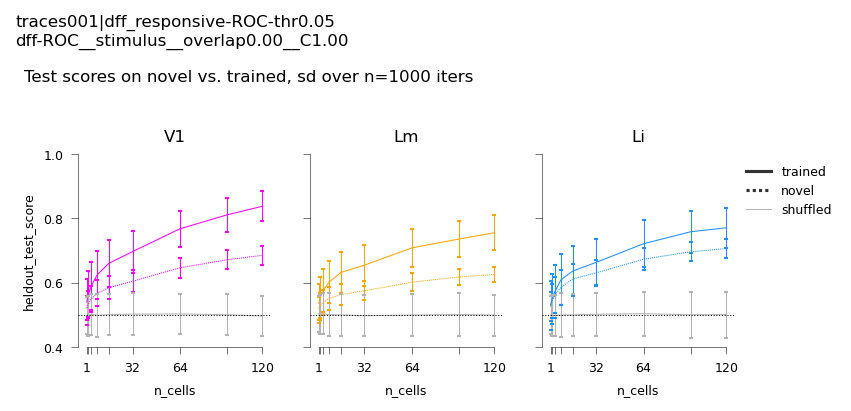

In [95]:
lw=0.5

plotd = mean_df[mean_df['n_cells']<=max_ncells].copy()
plotd['novel_labels'] = None
plotd.loc[plotd['novel'], 'novel_labels'] = 'novel'
plotd.loc[~plotd['novel'], 'novel_labels'] = 'trained'
#cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}
cond_styles = {'trained': '', 'novel': (1,1)}

%matplotlib inline
metric='heldout_test_score'
if analysis_type=='by_ncells':
    fig, axn = pl.subplots(1,3, figsize=(6., 3), dpi=150, sharex=True, sharey=True)
    for vi, (va, df_) in enumerate(plotd.groupby('visual_area')):
        ai = visual_areas.index(va)
        ax=axn[ai]; ax.set_title(va);
        sns.lineplot(x='n_cells', y=metric, data=df_[df_.condition=='data'], ax=ax,
                style='novel_labels', dashes=cond_styles, ci='sd', err_style='bars',
                    color=area_colors[va], lw=lw, 
                     err_kws=dict(linewidth=lw, capsize=1))
        sns.lineplot(x='n_cells', y=metric, data=df_[df_.condition=='shuffled'],ax=ax,
                color=[0.7]*3, ci='sd', err_style='bars', label='shuffled', 
                    linestyle='-', lw=lw, 
                     err_kws=dict(linewidth=lw, capsize=1))
        ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
        ax.legend_.remove()
    axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.07, right=0.8, bottom=0.25, top=0.7,
                      wspace=0.2)
for ax in axn:
    ax.set_yticks(np.linspace(0.4, 1, 4))
    ax.set_ylim([0.4,1])
    ax.set_xticks(sample_sizes)
    ax.set_box_aspect(1)
    ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
sns.despine(trim=True)

fig.text(0.01, 0.85, 'Test scores on novel vs. trained, sd over n=%i iters' % n_iters,
        fontsize=8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

figname = 'trained_v_novel_byncells__%s%s' % (aggr_id, overlap_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR,  '%s.svg' % figname))

print(curr_dst_dir, figname)

In [90]:
aggr_id

'dff-ROC__stimulus__overlap0.00__C1.00'

<IPython.core.display.Javascript object>


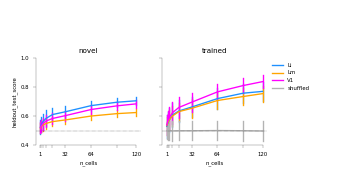

In [96]:

%matplotlib notebook
metric='heldout_test_score'
if analysis_type=='by_ncells':
    fig, axn = pl.subplots(1,2, figsize=(5.5, 3), sharex=True, sharey=True)
    for ai, (cond, df_) in enumerate(plotd.groupby(['novel_labels'])):
        ax=axn[ai]; ax.set_title(cond);
        sns.lineplot(x='n_cells', y=metric, data=df_[df_.condition=='data'], ax=ax,
                    ci='sd', err_style='bars',
                    hue='visual_area', palette=area_colors)
        sns.lineplot(x='n_cells', y=metric, ax=ax,
                    data=df_[df_.condition=='shuffled'],
                    color=[0.7]*3, ci='sd', err_style='bars', label='shuffled', 
                    linestyle='-')
        ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
        ax.legend_.remove()
    axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.1, right=0.75, bottom=0.25, top=0.7,
                      wspace=0.2)
for ax in axn:
    ax.set_yticks(np.linspace(0.4, 1, 4))
    ax.set_ylim([0.4,1])
    ax.set_xticks(sample_sizes)
    ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
sns.despine(trim=True)

In [98]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00'

#### Discrimination performance (train config = test config)

<IPython.core.display.Javascript object>


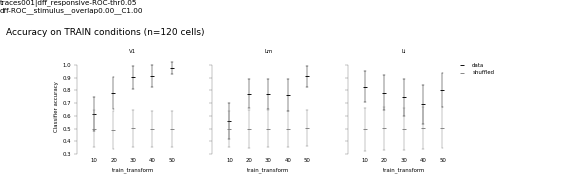

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 trainconfigs__dff-ROC__stimulus__overlap0.00__C1.00


In [100]:
%matplotlib notebook
#max_ncells = 96
curr_ncells=max_ncells

traind = iterdf[~(iterdf.novel) & (iterdf['n_cells']==curr_ncells)].copy()

fg = sns.FacetGrid(traind, col='visual_area', col_order=visual_areas, 
                   height=3, aspect=1)
fg.map(sns.pointplot, 'train_transform', 'heldout_test_score', 'condition', 
      palette={'data': 'k', 'shuffled': 'gray'}, markers='_', ci='sd',
       capsize=0.1, scale=0.5, errwidth=0.5, join=False)
fg.set_titles(col_template="{col_name}")

sns.despine(bottom=True, offset=8, trim=True)
for ai,ax in enumerate(fg.fig.axes):
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xticklabels([int(s) for s in sorted(traind['train_transform'].unique())])
    ax.set_box_aspect(1)
    if ai==0:
        ax.set_ylabel('Classifier accuracy')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.12, bottom=0.2, right=0.8, top=0.7)
pplot.label_figure(fg.fig, '%s\n%s' % (data_id, aggr_id))

fg.fig.text(0.01, 0.82, 'Accuracy on TRAIN conditions (n=%i cells)' % curr_ncells)
figname = 'trainconfigs__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir,  '%s.svg' % figname))
print(curr_dst_dir, figname)

#### Trained vs Novel, by training condition

<IPython.core.display.Javascript object>


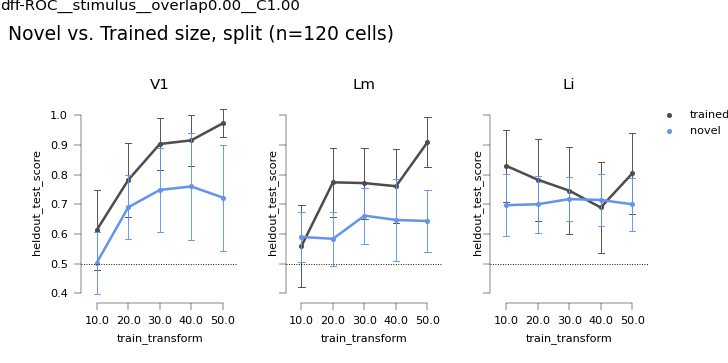

In [101]:
%matplotlib notebook
plotd = iterdf[iterdf['n_cells']==max_ncells].copy()
plotd['novel_labels'] = None
plotd.loc[plotd['novel'], 'novel_labels'] = 'novel'
plotd.loc[~plotd['novel'], 'novel_labels'] = 'trained'
cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}

metric = 'heldout_test_score'
fig, axn = pl.subplots(1,3, figsize=(6, 3), dpi=150, sharex=True, sharey=True)
for vi, (va, df_) in enumerate(plotd.groupby('visual_area')):
    ai = visual_areas.index(va)
    ax=axn[ai]
    ax.set_title(va)
    sns.pointplot(x='train_transform', y=metric, data=df_[df_.condition=='data'], 
            ax=ax, scale=0.5, palette=cond_colors, hue='novel_labels',
            ci='sd',capsize=0.2, errwidth=0.5, markers='.')
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.legend_.remove()
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.75,
                  wspace=0.3)
sns.despine(trim=True)
pplot.label_figure(fig, aggr_id)
fig.text(0.01, 0.9, 'Novel vs. Trained size, split (n=%i cells)' % max_ncells)

figname = 'trained_v_novel_transforms__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

## Generalization score

In [102]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [103]:
# curr_ncells=128
metric = 'heldout_test_score'
pass_list=[]
for (va, nc), g in mean_df.groupby(['visual_area', 'n_cells']):
    traindf = g[~(g.novel)].sort_values(by='iteration')
    # Get values for all iterations at current NCELLS & COND (500 iters):
    ddf = traindf[traindf.condition=='data'][metric].reset_index(drop=True)
    ddf_s = traindf[traindf.condition=='shuffled'][metric].reset_index(drop=True)
    # Get indices were data > shuffled
    pass_ixs = ddf[ddf>ddf_s].index.to_numpy()
    pass_list.append(g[g.iteration.isin(pass_ixs)])

passdf = pd.concat(pass_list, axis=0)

In [104]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [105]:
metric='heldout_test_score'
byiter_novel = dec.generalization_score_by_iter(passdf, max_ncells=curr_ncells)

In [106]:
gen_df = byiter_novel[(byiter_novel['n_cells']==curr_ncells)].drop_duplicates()
gen_df.shape

(2996, 15)

In [107]:
gen_df.dtypes

visual_area            object
condition              object
iteration               int64
n_cells                 int64
novel                    bool
heldout_test_score    float64
C                     float64
randi                 float64
train_transform       float64
test_transform        float64
n_trials              float64
randi_cells           float64
intact                   bool
overlap_thr           float64
generalization        float64
dtype: object

<IPython.core.display.Javascript object>


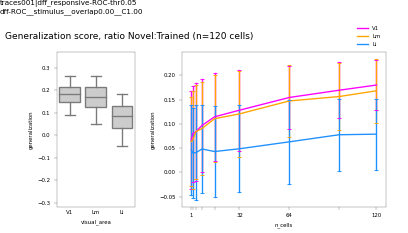

In [108]:
metric='generalization'
multi_comp_test='fdr_bh'
import matplotlib.gridspec as gridspec
fig = pl.figure(figsize=(7,4))
gs = gridspec.GridSpec(1,3) # figsize=(6,3))

ax=fig.add_subplot(gs[0])
sns.boxplot(x='visual_area', y=metric, 
            data=gen_df, ax=ax, whis=(5, 95), fliersize=0,
            order=visual_areas, color=[0.8]*3)
# ax.set_yticks(np.linspace(0.5, 1, 3))
# ax.set_yticks(np.linspace(0.6, 1.2, 4))
# ax.set_ylim([0.6,1.2])
ax.tick_params(which='both', axis='x', size=0)

ax=fig.add_subplot(gs[1:])
sns.lineplot(x='n_cells', y=metric, data=byiter_novel, ax=ax, 
             hue='visual_area', ci='sd',err_style='bars', err_kws={'capsize':2},
             palette=area_colors, hue_order=visual_areas)

#ax.set_yticks(np.linspace(0.6, 1.2, 4))
#ax.set_ylim([0.6,1.2])
ax.set_xticks(sample_sizes)
ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
fig.text(0.01, 0.85, 'Generalization score, ratio Novel:Trained (n=%i cells)' \
         % curr_ncells)

    
# legend
ax.legend(bbox_to_anchor=(1., 1.), loc='lower right', frameon=False,
          title='', markerscale=0.5, fontsize=6)
pl.subplots_adjust(wspace=0.6, right=0.85, top=0.8, bottom=0.2)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))


In [110]:
gen_df.groupby('visual_area')['generalization'].describe()

,count,mean,std,min,25%,50%,75%,max
visual_area,,,,,,,,
Li,998.0,0.078734,0.073179,-0.287081,0.030977,0.086447,0.129934,0.249624
Lm,998.0,0.167894,0.066089,-0.165230,0.126740,0.171325,0.214388,0.340253
V1,1000.0,0.179757,0.052170,-0.019201,0.146552,0.183190,0.213685,0.323682


In [111]:
mean_gen = gen_df.groupby('visual_area').mean()
mean_gen

,iteration,n_cells,novel,heldout_test_score,C,randi,train_transform,test_transform,n_trials,randi_cells,intact,overlap_thr,generalization
visual_area,,,,,,,,,,,,,
Li,499.406814,120.0,True,0.706048,1.0,5005.688778,30.0,30.0,44.933868,4815.849699,True,0.0,0.078734
Lm,499.191383,120.0,True,0.625390,1.0,4923.410020,30.0,30.0,58.000000,5021.808617,True,0.0,0.167894
V1,499.500000,120.0,True,0.684921,1.0,4973.250800,30.0,30.0,58.000000,4871.768000,True,0.0,0.179757


<IPython.core.display.Javascript object>


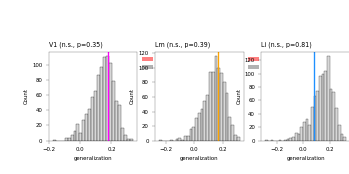

In [112]:
shuff_df = gen_df.copy()
shuff_df['visual_area'] = shuff_df['visual_area'].sample(frac=1, replace=False).values

fig, axn = pl.subplots(1, 3, figsize=(6,3))
for va, vg in shuff_df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.histplot(x='generalization', data=vg, ax=ax,
                 color=[0.8]*3, cumulative=False, common_norm=False)
    true_score = mean_gen.loc[va]['generalization']
    
    ax.axvline(x=true_score, color=area_colors[va])
    ax.set_box_aspect(1)
    
    shuff_dist = np.array(sorted(vg['generalization'].values))
    n_extreme = len(np.where(shuff_dist>=true_score)[0])
    pv = n_extreme/len(shuff_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    if vi==2:
        legh = pplot.custom_legend_markers(colors=['r', [0.4]*3], 
                                    labels=['true diffs', 'shuffled'], 
                                    use_patch=True, alpha=0.5)
        ax.legend(handles=legh, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    #ax.axvline(x=true_diff, ls='-', c='r', lw=2)
    ax.set_title('%s (%s, p=%.2f)' % (va, sig_str, pv),
                 loc='left', fontsize=7)
    

## Is this difference significantly greater than chance?

In [113]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [138]:

# curr_ncells = 120
data_ = iterdf[(iterdf.n_cells==curr_ncells) & (iterdf.condition=='data')].copy()
diffs = dec.permutation_test_trained_v_novel(data_)

<IPython.core.display.Javascript object>


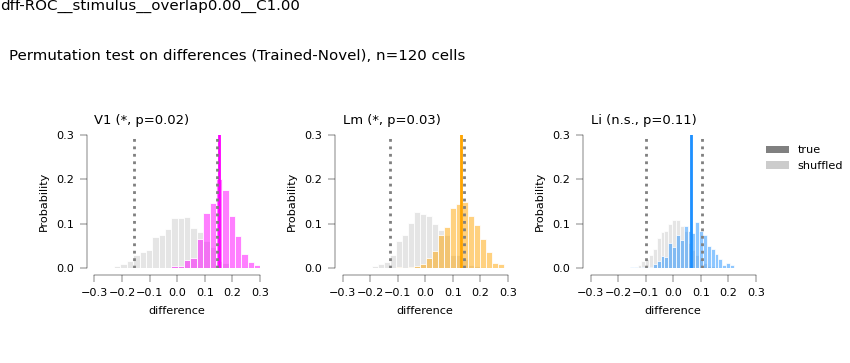

|    | visual_area   |   p-val |
|---:|:--------------|--------:|
|  0 | Li            |   0.111 |
|  1 | Lm            |   0.034 |
|  2 | V1            |   0.016 |
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 permutation_test_trained-v-novel-diffs


In [139]:
shuff_color=[0.8]*3
s_=[]
fig, axn = pl.subplots(1,3, figsize=(7, 3), sharex=True, sharey=False, dpi=150)
for vi, (va, vg) in enumerate(diffs.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    sns.histplot(x='difference', hue='trained_v_novel', data=vg, ax=ax, alpha=0.5,
                palette={'shuffled': shuff_color, 'true': area_colors[va]},
                 stat='probability', legend=True,edgecolor='w', common_norm=False)
    meas_mean = vg[vg.trained_v_novel=='true']['difference'].mean()
    ax.axvline(x=meas_mean, color=area_colors[va])
    shuff_dist = sorted(vg[vg.trained_v_novel=='shuffled']['difference'].values)
    n_below = len(np.where(shuff_dist>=meas_mean)[0])
    pv = n_below/len(shuff_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    ax.set_title('%s (%s, p=%.2f)' % (va, sig_str, pv), loc='left', fontsize=7)
    stat_ = pd.Series({'visual_area': va, 'p-val': pv})
    s_.append(stat_)
    c_lo, c_hi = hutils.get_empirical_ci(shuff_dist)
    ax.axvline(x=c_lo, color=[0.5]*3, ls=':')
    ax.axvline(x=c_hi, color=[0.5]*3, ls=':')
    
    if va=='Li':
        leg_h = pplot.custom_legend_markers(colors=[[0.5]*3, shuff_color],
                                           labels=['true', 'shuffled'], 
                                           use_patch=True)
        ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                 title=None)
    else:
        ax.legend_.remove()
    #ax.set_ylim([0, 0.12])
    ax.set_xlim([-0.3, 0.3])
    ax.set_xticks(np.linspace(-0.3, 0.3, 7))
    ax.set_yticks(np.linspace(0, 0.3, 4))
    ax.set_yticks(np.linspace(0, 0.3, 4))
    ax.set_box_aspect(0.8)
sns.despine(trim=True, offset=4)
statdf = pd.concat(s_, axis=1).T
print(statdf.to_markdown())

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.75,
                  wspace=0.5)

fig.text(0.01, 0.85,\
         "Permutation test on differences (Trained-Novel), n=%i cells" \
         % max_ncells, fontsize=8)

pplot.label_figure(fig, aggr_id)
figname = 'permutation_test_trained-v-novel-diffs'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [140]:
curr_ncells

120

In [141]:
diffs[diffs.trained_v_novel=='true'].groupby(['visual_area'])['difference'].describe()

,count,mean,std,min,25%,50%,75%,max
visual_area,,,,,,,,
Li,1000.0,0.064351,0.059252,-0.157895,0.023420,0.066810,0.104957,0.219737
Lm,1000.0,0.129621,0.057215,-0.099138,0.091307,0.129885,0.170115,0.285920
V1,1000.0,0.152329,0.049646,-0.014080,0.119253,0.153305,0.184555,0.302011


<IPython.core.display.Javascript object>


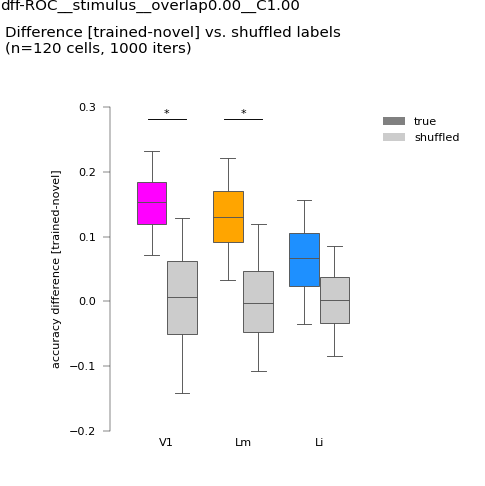

  visual_area  p-val
1          Lm  0.034
  visual_area  p-val
2          V1  0.016
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 permutation_test_diff_boxplot


In [143]:
shuff_color=[0.8]*3
fig, ax = pl.subplots(figsize=(4,4), dpi=150)
sns.boxplot(x='visual_area', y='difference', data=diffs, ax=ax,
            order=visual_areas, hue='trained_v_novel', 
            palette={'shuffled': shuff_color, 'true': area_colors[va]},
           fliersize=0, linewidth=0.5, whis=[5, 95])
pl.subplots_adjust(bottom=0.2, right=0.8)
ax.set_box_aspect(1.25)
ax.set_ylim([-0.2, 0.3])
sns.despine(bottom=True, offset=2)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
ax.set_ylabel('accuracy difference [trained-novel]')
for bi, va in zip(np.arange(0, len(ax.artists))[0::2], visual_areas):
    bx = ax.artists[bi]
    bx.set_facecolor(area_colors[va])
# stats
pplot.annotate_sig_on_paired_plot(ax, diffs, statdf, 'difference', 
                            offset=-0.02, h=0.00, lw=0.5, stat='p-val')
# legend    
leg_h = pplot.custom_legend_markers(colors=[[0.5]*3, shuff_color],
                                   labels=['true', 'shuffled'], use_patch=True)
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False,
         title=None)

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8)
fig.text(0.01, 0.9, \
    'Difference [trained-novel] vs. shuffled labels\n(n=%i cells, %i iters)' % (curr_ncells, n_iters),\
         fontsize=8)

pplot.label_figure(fig, aggr_id)
figname = 'permutation_test_diff_boxplot'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

#### Calculate "generalization score"

In [119]:
# def calculate_difference_scores(byiter_data):
#     cols = ['visual_area', 'n_cells', 'iteration'] #, 'train_transform', 'test_transform']
#     diffdf = byiter_data[cols].copy().reset_index(drop=True).drop_duplicates()
#     diffdf = diffdf.sort_values(by=['iteration', 'visual_area'])

#     byiter_data = byiter_data.sort_values(by=['iteration', 'visual_area'])
#     true_diffs = byiter_data[(~byiter_data.novel)]['heldout_test_score'].values\
#                 - byiter_data[(byiter_data.novel)]['heldout_test_score'].values
#     diffdf['difference'] = true_diffs
    
#     return diffdf

In [120]:
itershuff.n_cells.unique()

array([  1,   2,   4,   8,  16,  96,  32,  64, 128, 141,  94, 120])

In [121]:
print(curr_ncells)
itershuff[(itershuff.n_cells==curr_ncells) & (itershuff.condition=='data')]

120


,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells,randi_cells,visual_area,datakey,intact,noise_corrs,overlap_thr
285000,0.003351,0.000298,0.626667,1.0,0.416667,1.0,6758,data,10.0,10.0,58,False,0,120,4774,Li,aggregate,True,intact,0.0
285002,0.003351,0.000298,0.626667,1.0,0.586207,1.0,6758,data,10.0,20.0,58,True,0,120,4774,Li,aggregate,True,intact,0.0
285003,0.003351,0.000298,0.626667,1.0,0.586207,1.0,6758,data,10.0,30.0,58,True,0,120,4774,Li,aggregate,True,intact,0.0
285004,0.003351,0.000298,0.626667,1.0,0.603448,1.0,6758,data,10.0,40.0,58,True,0,120,4774,Li,aggregate,True,intact,0.0
285005,0.003351,0.000298,0.626667,1.0,0.620690,1.0,6758,data,10.0,50.0,58,True,0,120,4774,Li,aggregate,True,intact,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944994,0.000788,0.000340,1.000000,1.0,1.000000,1.0,8946,data,50.0,50.0,58,False,749,120,5224,V1,aggregate,True,intact,0.0
944996,0.000788,0.000340,1.000000,1.0,0.482759,1.0,8946,data,50.0,10.0,58,True,749,120,5224,V1,aggregate,True,intact,0.0
944997,0.000788,0.000340,1.000000,1.0,0.724138,1.0,8946,data,50.0,20.0,58,True,749,120,5224,V1,aggregate,True,intact,0.0
944998,0.000788,0.000340,1.000000,1.0,0.793103,1.0,8946,data,50.0,30.0,58,True,749,120,5224,V1,aggregate,True,intact,0.0


(75000, 20)


<IPython.core.display.Javascript object>


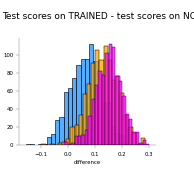

Text(0.01, 0.9, 'Test scores on TRAINED - test scores on NOVEL')

In [122]:
# curr_ncells=94 #max_ncells #128

data_df = iterdf[(iterdf.n_cells==curr_ncells) & (iterdf.condition=='data')].copy()
print(data_df.shape)
data_scores = dec.average_within_iterations_by_ncells(data_df, 
                                analysis_type='by_ncells',
                                test_type='size_single',
                                grouper=['visual_area', 'condition', 'iteration'])
diff_scores = dec.calculate_difference_scores(data_scores)

fg = sns.FacetGrid(data=diff_scores, height=3, 
                  hue='visual_area', palette=area_colors)
fg.map(sns.histplot, 'difference')
ax.axvline(x=0, ls=':', c='k', lw=1)


pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.8)
fg.fig.text(0.01, 0.9, 'Test scores on TRAINED - test scores on NOVEL')

In [123]:
for va, vg in diff_scores.groupby(['visual_area']):
    shuff_dist = np.array(sorted(vg['difference'].values))
    n_extreme = len(np.where(shuff_dist<=0)[0])
    pv = n_extreme/len(shuff_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    print('%s (%s, p=%.2f)' % (va, sig_str, pv))


Li (n.s., p=0.15)
Lm (*, p=0.01)
V1 (**, p=0.00)


In [124]:
shuff_dist

array([-0.01408046, -0.00862069, -0.00574713, -0.00287356,  0.01149425,
        0.01695402,  0.02241379,  0.02614943,  0.02701149,  0.02844828,
        0.02844828,  0.02902299,  0.0295977 ,  0.03045977,  0.03247126,
        0.03247126,  0.03505747,  0.03678161,  0.03678161,  0.04022989,
        0.0408046 ,  0.04482759,  0.04482759,  0.04712644,  0.04798851,
        0.04856322,  0.04856322,  0.04913793,  0.05287356,  0.05316092,
        0.05344828,  0.05517241,  0.05775862,  0.05775862,  0.05948276,
        0.05977011,  0.06005747,  0.06091954,  0.06178161,  0.06206897,
        0.06321839,  0.06551724,  0.06609195,  0.06666667,  0.06666667,
        0.06695402,  0.06867816,  0.06954023,  0.07126437,  0.07126437,
        0.07155172,  0.07155172,  0.07212644,  0.07385057,  0.07413793,
        0.07442529,  0.07471264,  0.07471264,  0.075     ,  0.07528736,
        0.07557471,  0.07643678,  0.07672414,  0.07758621,  0.07758621,
        0.07816092,  0.07902299,  0.07931034,  0.0795977 ,  0.07

In [125]:
shuff_df

,visual_area,condition,iteration,n_cells,novel,heldout_test_score,C,randi,train_transform,test_transform,n_trials,randi_cells,intact,overlap_thr,generalization
23,Li,data,0,120,True,0.705263,1.0,5134.8,30.0,30.0,38.0,163.0,True,0.0,0.118421
51,V1,data,1,120,True,0.705172,1.0,4596.2,30.0,30.0,58.0,9393.0,True,0.0,0.136524
79,V1,data,2,120,True,0.734211,1.0,3029.4,30.0,30.0,38.0,8803.0,True,0.0,0.021053
107,Lm,data,3,120,True,0.698276,1.0,6862.0,30.0,30.0,58.0,5040.0,True,0.0,0.144968
135,Lm,data,4,120,True,0.685345,1.0,5191.6,30.0,30.0,58.0,2671.0,True,0.0,0.160802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96919,Lm,data,995,120,True,0.691379,1.0,8095.0,30.0,30.0,58.0,7063.0,True,0.0,0.117388
96939,Li,data,996,120,True,0.662931,1.0,2429.4,30.0,30.0,58.0,9302.0,True,0.0,0.220081
96959,Li,data,997,120,True,0.700000,1.0,4824.0,30.0,30.0,58.0,8963.0,True,0.0,0.192308
96979,V1,data,998,120,True,0.685345,1.0,6068.2,30.0,30.0,58.0,9548.0,True,0.0,0.106072


In [126]:
# curr_ncells=128

<IPython.core.display.Javascript object>


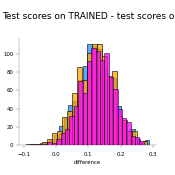

Text(0.01, 0.9, 'Test scores on TRAINED - test scores on NOVEL')

In [127]:

shuff_df = itershuff[(itershuff.n_cells==curr_ncells) & (itershuff.condition=='data')].copy()
shuff_scores = dec.average_within_iterations_by_ncells(shuff_df, 
                                analysis_type='by_ncells',
                                test_type='size_single',
                                grouper=['visual_area', 'condition', 'iteration'])
diff_scores_shuff = dec.calculate_difference_scores(shuff_scores)

fg = sns.FacetGrid(data=diff_scores_shuff, height=3, 
                  hue='visual_area', palette=area_colors)
fg.map(sns.histplot, 'difference')
ax.axvline(x=0, ls=':', c='k', lw=1)


pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.8)
fg.fig.text(0.01, 0.9, 'Test scores on TRAINED - test scores on NOVEL')

In [128]:
import itertools

import statsmodels.stats.multitest as smulti

import pingouin as pg
import scipy.stats as spstats

In [129]:
diff_scores.shape, diff_scores_shuff.shape #.reload(pplot)

((3000, 4), (3000, 4))

In [130]:
diff_scores['condition'] = 'true'
diff_scores_shuff['condition'] = 'shuffled'
DIFFS = pd.concat([diff_scores, diff_scores_shuff], axis=0, ignore_index=True)
DIFFS.head()

,visual_area,n_cells,iteration,difference,condition
0,Li,120,0,0.094737,true
1,Lm,120,0,0.126149,true
2,V1,120,0,0.044828,true
3,Li,120,1,0.111494,true
4,Lm,120,1,0.145690,true


In [131]:
v_combos = list(itertools.combinations(visual_areas, 2))
df_list=[]
for vi, (v1, v2) in enumerate(v_combos):
    # Original diff. distributions
    for shuffcond, diffs in DIFFS.groupby('condition'):
        curr_scores = diffs[diffs.visual_area.isin([v1, v2])].copy()
        v1_df = curr_scores[curr_scores.visual_area==v1]\
                [['iteration', 'difference', 'visual_area']].copy()
        v2_df = curr_scores[curr_scores.visual_area==v2]\
                [['iteration', 'difference', 'visual_area']].copy()
        diffs_ = pd.merge(v1_df, v2_df, on=['iteration'], how='outer',
                          suffixes=('_%s' % v1, '_%s' % v2))
        diffs_['difference'] = diffs_['difference_%s' % v1] \
                                - diffs_['difference_%s' % v2]
        true_diff = diffs_['difference'].mean()
        diffs_['condition'] = shuffcond
        diffs_['area_pair'] = '%s_%s' % (v1, v2)
        df_list.append(diffs_[['area_pair', 'iteration', 'condition', 'difference']])


In [132]:
diff_v_shuff = pd.concat(df_list, axis=0, ignore_index=True)
diff_v_shuff.shape

(6000, 4)

In [133]:
diffs_

,iteration,difference_Lm,visual_area_Lm,difference_Li,visual_area_Li,difference,condition,area_pair
0,0,0.126149,Lm,0.094737,Li,0.031413,true,Lm_Li
1,1,0.145690,Lm,0.111494,Li,0.034195,true,Lm_Li
2,2,0.143678,Lm,0.015789,Li,0.127889,true,Lm_Li
3,3,0.087644,Lm,0.118391,Li,-0.030747,true,Lm_Li
4,4,0.093678,Lm,0.131322,Li,-0.037644,true,Lm_Li
...,...,...,...,...,...,...,...,...
995,995,0.167241,Lm,0.100000,Li,0.067241,true,Lm_Li
996,996,0.122414,Lm,-0.030263,Li,0.152677,true,Lm_Li
997,997,0.279023,Lm,0.071053,Li,0.207970,true,Lm_Li
998,998,0.066954,Lm,-0.035526,Li,0.102480,true,Lm_Li


<IPython.core.display.Javascript object>


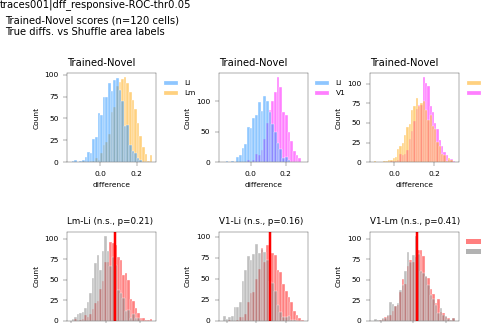

In [134]:
%matplotlib notebook
# v1='Li'
# v2 = 'Lm'
shuff_colors = {'true': 'r', 'shuffled': [0.5]*3}                      
s_list=[]
fig, axn = pl.subplots(2, 3, figsize=(6,4), dpi=100)
for vi, (vpair, diffs_) in enumerate(diff_v_shuff.groupby('area_pair')):
    v1, v2 = vpair.split('_')
    # Diff distribution for each area (TRAINED-NOVEL)
    ax=axn[0, vi] 
    curr_scores = DIFFS[(DIFFS.condition=='true') 
                        & (DIFFS.visual_area.isin([v1, v2]))].copy()
    sns.histplot(x='difference', data=curr_scores, ax=ax,
                 palette=area_colors, hue='visual_area', edgecolor='w')
    pplot.sns_histplot_legend(ax, title='')
    ax.set_title('Trained-Novel', loc='left')
    
    # shuffled
    ax=axn[1, vi]
    sns.histplot(x='difference', data=diffs_, ax=ax, alpha=0.5, edgecolor='w',
                hue='condition', palette=shuff_colors)
    meandiffs = diffs_.groupby('condition').mean()
    true_diff = float(meandiffs.loc['true']['difference'])
    shuff_diff = float(meandiffs.loc['shuffled']['difference'])
    if vi!=2:
        ax.legend_.remove()
    shuff_dist = np.array(sorted(diffs_[diffs_.condition=='shuffled']['difference'].values))
    n_extreme = len(np.where(shuff_dist>=true_diff)[0])
    pv = n_extreme/len(shuff_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    if vi==2:
        legh = pplot.custom_legend_markers(colors=['r', [0.4]*3], 
                                    labels=['true diffs', 'shuffled'], 
                                    use_patch=True, alpha=0.5)
        ax.legend(handles=legh, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    ax.axvline(x=true_diff, ls='-', c='r', lw=2)
    ax.set_title('%s-%s (%s, p=%.2f)' % (v1, v2, sig_str, pv),
                 loc='left', fontsize=7)
    stats0 = pd.Series({'v1': v1, 'v2': v2, 'true_diff': true_diff,
                       'shuff_diff': shuff_diff, 'p-val': pv})
    s_list.append(stats0)
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(wspace=0.7, hspace=0.7, bottom=0.1, top=0.8, right=0.85)

pplot.label_figure(fig,data_id)
fig.text(0.01, 0.9, 
    'Trained-Novel scores (n=%i cells)\nTrue diffs. vs Shuffle area labels' \
         % curr_ncells, fontsize=8)

figname = 'trained_vs_novel_shuffle_area_labels_n%icells' % curr_ncells

# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [73]:
# Kruskal-wallist:  nonparametric, one-way ANOVA on ranks
# Mann-Whitney U (Wilcoxon rank-sum test):  nonparametric, indep T_test
# Wilcoxon signed-rank test:  non-parametric version of paired T-test

# pg.kruskal(data=diff_scores, dv='difference', between='visual_area')

In [74]:
pd.concat(s_list, axis=1).T

,v1,v2,true_diff,shuff_diff,p-val
0,Lm,Li,0.064474,0.002466,0.224
1,V1,Li,0.08445,0.007742,0.182
2,V1,Lm,0.019976,0.005276,0.428


In [75]:
statsdf = pd.concat(s_list, axis=1).T
statsdf['p-val'] = statsdf['p-val'].astype(float)
statsdf['reject_null_uncorr'] = statsdf['p-val']<0.05

post_hoc='fdr_bh'
reject, pvals_corr = pg.multicomp(statsdf['p-val'].values, method=post_hoc)
statsdf['reject_null'] = reject
statsdf['p_adjusted'] = pvals_corr
statsdf.round(2)

,v1,v2,true_diff,shuff_diff,p-val,reject_null_uncorr,reject_null,p_adjusted
0,Lm,Li,0.064474,0.002466,0.22,False,False,0.34
1,V1,Li,0.08445,0.007742,0.18,False,False,0.34
2,V1,Lm,0.019976,0.005276,0.43,False,False,0.43


In [96]:
reject

array([False, False, False])

In [55]:
v1='V1'
v2 = 'Li'

curr_scores = diff_scores[diff_scores.visual_area.isin([v1, v2])].copy()

#v1_vals = diff_scores[diff_scores.visual_area==v1]['difference'].values
#v2_vals = diff_scores[diff_scores.visual_area==v2]['difference'].values

true_scores = data_scores[data_scores.visual_area.isin([v1, v2])].copy()
true_diffs = dec.calculate_difference_scores(true_scores)
print(true_scores.shape, true_diffs.shape)

(2000, 18) (1000, 4)


In [171]:
shuff_df = iterdf[(iterdf.n_cells==curr_ncells) & (iterdf.condition=='data')].copy()
shuff_df.head()

,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells,randi_cells,visual_area,datakey,intact,overlap_thr
135000,0.154873,0.000715,0.966667,1.0,1.000000,1.0,2053,data,10.0,10.0,38,False,500,120,5233,Li,aggregate,True,0.0
135002,0.154873,0.000715,0.966667,1.0,0.894737,1.0,2053,data,10.0,20.0,38,True,500,120,5233,Li,aggregate,True,0.0
135003,0.154873,0.000715,0.966667,1.0,0.789474,1.0,2053,data,10.0,30.0,38,True,500,120,5233,Li,aggregate,True,0.0
135004,0.154873,0.000715,0.966667,1.0,0.631579,1.0,2053,data,10.0,40.0,38,True,500,120,5233,Li,aggregate,True,0.0
135005,0.154873,0.000715,0.966667,1.0,0.578947,1.0,2053,data,10.0,50.0,38,True,500,120,5233,Li,aggregate,True,0.0


In [173]:
for (t1, t2), g in shuff_df[shuff_df.iteration==0]\
            .groupby(['train_transform', 'test_transform']):
    g

In [174]:
g

,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells,randi_cells,visual_area,datakey,intact,overlap_thr
150024,0.000752,0.000299,0.766667,1.0,0.875,1.0,3970,data,50.0,50.0,38,False,0,120,4684,Li,aggregate,True,0.0
330024,0.000868,0.000357,0.957778,1.0,1.000,1.0,858,data,50.0,50.0,58,False,0,120,5476,Lm,aggregate,True,0.0
532524,0.000821,0.000341,0.955556,1.0,1.000,1.0,6711,data,50.0,50.0,58,False,0,120,3552,V1,aggregate,True,0.0


In [176]:
shuffle_groups = ['train_transform', 'test_transform','iteration']

shuff_df['visual_area'] = shuff_df.groupby(shuffle_groups)['visual_area']\
                                          .transform(np.random.permutation)
shuff_df.head()

,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells,randi_cells,visual_area,datakey,intact,overlap_thr
135000,0.154873,0.000715,0.966667,1.0,1.000000,1.0,2053,data,10.0,10.0,38,False,500,120,5233,Li,aggregate,True,0.0
135002,0.154873,0.000715,0.966667,1.0,0.894737,1.0,2053,data,10.0,20.0,38,True,500,120,5233,Li,aggregate,True,0.0
135003,0.154873,0.000715,0.966667,1.0,0.789474,1.0,2053,data,10.0,30.0,38,True,500,120,5233,Li,aggregate,True,0.0
135004,0.154873,0.000715,0.966667,1.0,0.631579,1.0,2053,data,10.0,40.0,38,True,500,120,5233,Li,aggregate,True,0.0
135005,0.154873,0.000715,0.966667,1.0,0.578947,1.0,2053,data,10.0,50.0,38,True,500,120,5233,Lm,aggregate,True,0.0


In [177]:
shuff_scores = dec.average_within_iterations_by_ncells(shuff_df, 
                                analysis_type='by_ncells',
                                test_type='size_single',
                                grouper=['visual_area', 'condition', 'iteration'])
#shuff_scores = shuff_scores0[shuff_scores0.visual_area.isin([v1, v2])].copy()
shuff_diff_scores = dec.calculate_difference_scores(shuff_scores)

<IPython.core.display.Javascript object>


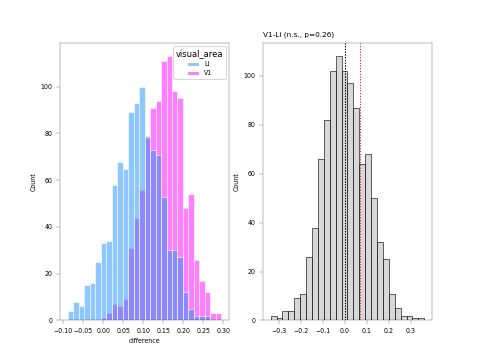

Text(0.0, 1.0, 'V1-Li (n.s., p=0.26)')

In [178]:
fig, axn = pl.subplots(1, 2)
ax=axn[0]
sns.histplot(x='difference', data=curr_scores, ax=ax,
                 palette=area_colors, hue='visual_area', edgecolor='w')

v1_vals = diff_scores[diff_scores.visual_area==v1]['difference'].values
v2_vals = diff_scores[diff_scores.visual_area==v2]['difference'].values
curr_diffs = v1_vals - v2_vals

v1_vals = shuff_diff_scores[shuff_diff_scores.visual_area==v1]['difference'].values
v2_vals = shuff_diff_scores[shuff_diff_scores.visual_area==v2]['difference'].values
curr_diffs_shuff = v1_vals - v2_vals
true_diff = np.mean(curr_diffs)

ax=axn[1]
sns.histplot(curr_diffs_shuff, ax=ax, color=[0.8]*3)
#sns.histplot(curr_diffs, ax=ax, color='r')

shuff_dist = np.array(sorted(curr_diffs_shuff))
n_extreme = len(np.where(shuff_dist>=true_diff)[0])
pv = n_extreme/len(shuff_dist)
if pv<0.05:
    sig_str='**' if pv<0.01 else '*'
else:
    sig_str='n.s.'
ax.axvline(x=0, ls=':', c='k', lw=1)
ax.axvline(x=true_diff, ls=':', c='r', lw=1)

ax.set_title('%s-%s (%s, p=%.2f)' % (v1, v2, sig_str, pv),
             loc='left', fontsize=7)


In [ ]:
import

In [136]:
shuff_diffs

,visual_area,n_cells,iteration,difference
0,Li,120,0,0.111872
2000,V1,120,0,0.189368
2,Li,120,1,0.021779
2002,V1,120,1,0.045221
4,Li,120,2,0.148382
...,...,...,...,...
3994,V1,120,997,0.098654
1996,Li,120,998,0.043073
3996,V1,120,998,0.157426
1998,Li,120,999,0.058500


In [117]:
# shuff_scores = data_scores[data_scores.visual_area.isin([v1, v2])].copy()
# # vals =shuff_scores['visual_area'].sample(frac=1).values
# shuff_scores['visual_area'] = shuff_scores.groupby(['novel', 'iteration'])['visual_area']\
#                                           .transform(np.random.permutation)
# shuff_scores[shuff_scores.visual_area==v1]
# # shuff_scores['visual_area'] = vals
# # shuff_diffs = dec.calculate_difference_scores(shuff_scores)
# d1 = shuff_scores[shuff_scores.visual_area==v1][['heldout_test_score', 'novel']]
# d2 = shuff_scores[shuff_scores.visual_area==v2][['heldout_test_score', 'novel']]
# d1

In [118]:
# diffs1 = d1[d1.novel].sort_index()['heldout_test_score'].values \
#             - d1[~d1.novel].sort_index()['heldout_test_score']
# diffs2 = d2[d2.novel].sort_index()['heldout_test_score'].values \
#             - d2[~d2.novel].sort_index()['heldout_test_score']

# diffs_ = diffs1 - diffs2

<IPython.core.display.Javascript object>


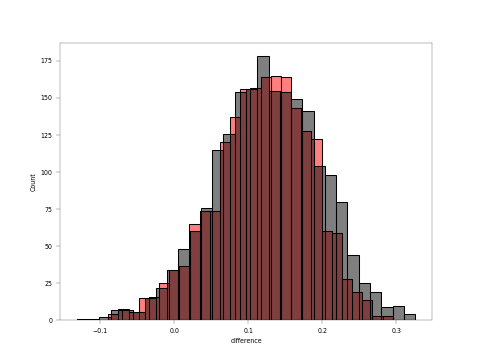

<AxesSubplot:xlabel='difference', ylabel='Count'>

In [119]:
fig, ax =pl.subplots()
sns.histplot(x='difference', data=true_diffs, color='r', alpha=0.5, ax=ax)
# sns.histplot(diffs_, color=[0.8]*3, alpha=0.5, ax=ax)

sns.histplot(x='difference', data=shuff_diffs, color='k', alpha=0.5, ax=ax)


In [20]:
import itertools

<IPython.core.display.Javascript object>


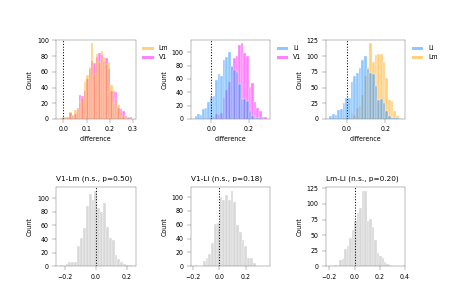

In [21]:
v1='Li'
v2 = 'Lm'
v_combos = list(itertools.combinations(visual_areas, 2))

fig, axn = pl.subplots(2, 3, figsize=(6,4), dpi=100)
for vi, (v1, v2) in enumerate(v_combos):

    curr_scores = diff_scores[diff_scores.visual_area.isin([v1, v2])].copy()
    ax=axn[0, vi]
    sns.histplot(x='difference', data=curr_scores, ax=ax,
                 palette=area_colors, hue='visual_area', edgecolor='w')
    ax.axvline(x=0, ls=':', c='k', lw=1)
    pplot.sns_histplot_legend(ax, title='')
    v1_vals = diff_scores[diff_scores.visual_area==v1]['difference'].values
    v2_vals = diff_scores[diff_scores.visual_area==v2]['difference'].values
    curr_diffs = v1_vals - v2_vals

    ax=axn[1, vi]
    sns.histplot(curr_diffs, ax=ax, color=[0.8]*3, edgecolor='w')
    shuff_dist = np.array(sorted(curr_diffs))
    n_extreme = len(np.where(shuff_dist<=0)[0])
    pv = n_extreme/len(shuff_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    ax.axvline(x=0, ls=':', c='k', lw=1)
    ax.set_title('%s-%s (%s, p=%.2f)' % (v1, v2, sig_str, pv),
                 loc='left', fontsize=7)
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(wspace=0.7, hspace=0.7, bottom=0.1, right=0.9)

In [62]:
len(shuff_dist)

1000

In [30]:
import itertools

<IPython.core.display.Javascript object>


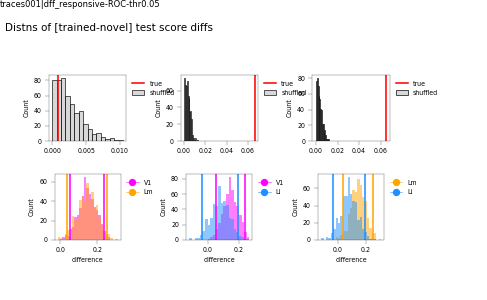

In [31]:
n_shuff=500
p_vals = []
metric='difference'
v_combos = list(itertools.combinations(visual_areas, 2))

fig, axn = pl.subplots(2, len(v_combos), figsize=(6.5,4))
for ai, (v1, v2) in enumerate(v_combos):
    v_list = [v1, v2]
    a_ = diff_scores[diff_scores.visual_area==v1][metric]
    b_ = diff_scores[diff_scores.visual_area==v2][metric]
    true_ = abs(a_.mean() - b_.mean())

    combined_ = pd.concat([a_, b_], axis=0, ignore_index=True).values
    shuff_=[]
    for n in range(n_shuff):
        np.random.shuffle(combined_)
        i = np.mean(combined_[0:500])
        v = np.mean(combined_[500:])
        diff_s = abs(i-v)
        shuff_.append(diff_s)
    shuff = np.array(shuff_)
    pv_ = len(np.where(shuff>=true_)[0])/n_shuff
    p_vals.append(pd.Series({'v1': v1, 'v2': v2, 'p_val': pv_}))
    
    ax=axn[0, ai]
    sns.histplot(shuff, color=[0.8]*3, ax=ax, label='shuffled')
    ax.axvline(x=true_, color='r', label='true')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

    ax=axn[1, ai]
    c1= area_colors[v1]
    c2 = c2=area_colors[v2]
    sns.histplot(x=metric, hue='visual_area', ax=ax,
                 data=diff_scores[diff_scores.visual_area.isin(v_list)], 
                 palette={v1:c1, v2: c2}, fill=True, edgecolor=None)
    c_lo, c_hi = hutils.get_empirical_ci(diff_scores[diff_scores.visual_area==v1][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)

    c_lo, c_hi = hutils.get_empirical_ci(diff_scores[diff_scores.visual_area==v2][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    leg_h = pplot.custom_legend_markers(colors=[c1, c2], labels=[v1, v2])
    ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.75, wspace=0.7, hspace=0.5)
fig.text(0.01, 0.9, "Distns of [trained-novel] test score diffs")

pplot.label_figure(fig, data_id)


In [49]:

diffs = dec.permutation_test_trained_v_novel(data_df)
diffs.head()

,visual_area,n_cells,iteration,difference,trained_v_novel
0,Li,128,0,0.111842,true
1,Lm,128,0,0.044828,true
2,V1,128,0,0.165230,true
3,Li,128,1,0.144737,true
4,Lm,128,1,0.177586,true


<IPython.core.display.Javascript object>


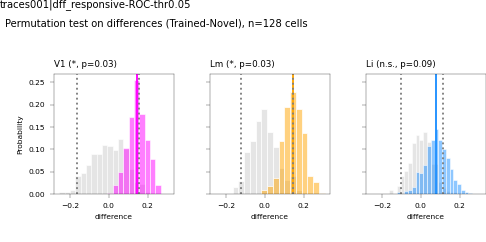

In [51]:
shuff_color=[0.8]*3

fig, axn = pl.subplots(1,3, figsize=(6,3), sharex=True, sharey=True)

for va, vg in diffs.groupby(['visual_area']):
    vi = visual_areas.index(va)
    ax=axn[vi]
    curr_colors= area_colors.copy()
    sns.histplot(x='difference', hue='trained_v_novel', data=vg, ax=ax, alpha=0.5,
                palette={'shuffled': shuff_color, 'true': curr_colors[va]},
                stat='probability', legend=True, common_norm=False,
                edgecolor='w')
    
    meas_mean = vg[vg.trained_v_novel=='true']['difference'].mean()
    ax.axvline(x=meas_mean, color=curr_colors[va])
    shuff_dist = sorted(vg[vg.trained_v_novel=='shuffled']['difference'].values)
    n_extreme = len(np.where(shuff_dist>=meas_mean)[0])
    pv = n_extreme/len(shuff_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    ax.set_title('%s (%s, p=%.2f)' % (va, sig_str, pv), loc='left', fontsize=7)
    
    c_lo, c_hi = hutils.get_empirical_ci(shuff_dist)
    ax.axvline(x=c_lo, color=[0.5]*3, ls=':')
    ax.axvline(x=c_hi, color=[0.5]*3, ls=':')
    if va=='Li':
        leg_h = pplot.custom_legend_markers(colors=[[0.5]*3, shuff_color],
                                           labels=['true', 'shuffled'], 
                                           use_patch=True)
        ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                 title=None)
    else:
        ax.legend_.remove()
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.3, hspace=0.5)
fig.text(0.01, 0.9,\
         "Permutation test on differences (Trained-Novel), n=%i cells" \
         % max_ncells, fontsize=8)

pplot.label_figure(fig, data_id)

In [34]:
# Shuffle
currd = byiter_data[byiter_data['n_cells']==max_ncells].copy()
d_list = []
for i in range(n_iters):
    d_=[]
    for va, all_vals in currd.groupby(['visual_area']):
        half_vs = all_vals['heldout_test_score'].sample(n=n_iters, replace=False)
        unused = [v for v in all_vals.index if v not in half_vs.index]
        other_vs = all_vals.loc[unused, 'heldout_test_score'].sample(n_iters)
        diff_ = np.mean(half_vs.values - other_vs.values)
        df_ = pd.DataFrame({diff_}, index=[i], columns=[va])
        d_.append(df_)
    d_list.append(pd.concat(d_, axis=1))
shuff_diff = pd.concat(d_list, axis=0).stack().reset_index()\
                .rename(columns={0: 'difference', 'level_1': 'visual_area'})
shuff_diff['condition'] = 'shuffled'
shuff_diff = shuff_diff.drop('level_0', 1)

In [35]:
# combine
true_diff = pd.concat([pd.DataFrame({'difference': d['difference'].values}, 
                                     index=[va]*n_iters) \
    for va, d in diffdf[diffdf['n_cells']==max_ncells].groupby('visual_area')], 
                       axis=0) #.reset_index(drop=True)
true_diff['condition'] = 'data'
true_diff['visual_area'] = true_diff.index.tolist()
true_diff = true_diff.reset_index(drop=True)
diffs = pd.concat([true_diff, shuff_diff], axis=0)

<IPython.core.display.Javascript object>


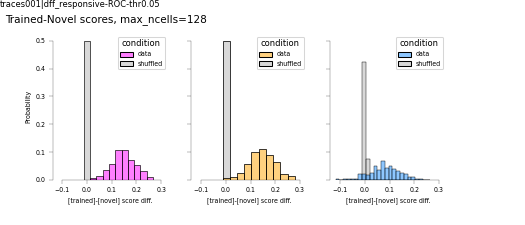

In [36]:
fig, axn = pl.subplots(1,3, figsize=(7, 3), sharex=True, sharey=True)
for vi, (va, df_) in enumerate(diffs.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    sns.histplot(x='difference', hue='condition', data=df_, ax=ax, alpha=0.5,
                palette={'data': area_colors[va], 'shuffled': [0.7]*3},
                 stat='probability', legend=True)
#                 cumulative=True, element='poly', fill=False)
    #true_mean = diffdf[diffdf.visual_area==va]['difference'].mean()
    #ax.axvline(x=true_mean, color=area_colors[va])
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.85)
for ax in axn:
    ax.set_xlabel('[trained]-[novel] score diff.')
    #ax.legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False, fontsize=6,)
    #          title='')
sns.despine(trim=True)

fig.text(0.01, 0.9, 'Trained-Novel scores, max_ncells=%i' % max_ncells)

pplot.label_figure(fig, data_id)

figname = 'hist_trained_vs_novel__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [37]:
import scipy.stats as spstats

In [38]:
data = [diffdf.loc[ids, 'difference'].values \
        for ids in diffdf.groupby('visual_area').groups.values()]

In [39]:
H, p = spstats.kruskal(*data)
H, p

(1022.2714023609312, 1.038928053918243e-222)

In [40]:
# import scikit_posthocs as skp
# skp.post_(df, val_col='SepalWidth', group_col='Species', p_adjust = 'holm')

<IPython.core.display.Javascript object>


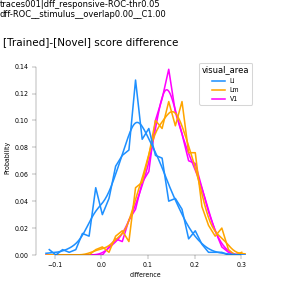

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 dist_trained_vs_novel_difference__dff-ROC__stimulus__overlap0.00__C1.00


In [41]:
fig, ax = pl.subplots(figsize=(4,4))
sns.histplot(x='difference', hue='visual_area', data=diffs[diffs.condition=='data'],
             ax=ax,
            cumulative=False, element='poly', fill=False, kde=True,
            palette=area_colors, stat='probability', common_norm=False)
# sns.histplot(x='difference', hue='visual_area', data=diffs[diffs.condition=='shuffled'],
#              ax=ax, line_kws={'linestyle': ':'},
#             cumulative=True, element='poly', fill=False,
#             palette=area_colors, stat='probability', common_norm=False)

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
sns.despine(trim=True)
fig.text(0.01, 0.85, '[Trained]-[Novel] score difference')
pl.subplots_adjust(bottom=0.15, top=0.8, left=0.12, right=0.85)
#figname='cumdist_trained_vs_novel_difference__%s' % aggr_id #% (dset_str, shuffle_str, errstr)
figname='dist_trained_vs_novel_difference__%s' % aggr_id #% (dset_str, shuffle_str, errstr)
pl.savefig(os.path.join(curr_dst_dir,  '%s.svg' % figname))
print(curr_dst_dir, figname)

In [42]:
diffs.groupby(['visual_area', 'condition']).count()

difference
visual_area condition            
Li          data              500
            shuffled          500
Lm          data              500
            shuffled          500
V1          data              500
            shuffled          500

In [240]:
pg.kruskal(data=plotd, dv='difference', between='visual_area')

,Source,ddof1,H,p-unc
Kruskal,visual_area,2,364.44635,7.269099e-80


<IPython.core.display.Javascript object>


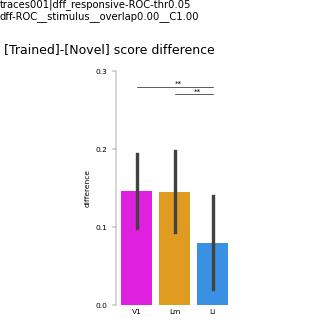

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 bar_trained_vs_novel_difference__dff-ROC__stimulus__overlap0.00__C1.00


In [243]:
plotd = diffs[diffs.condition=='data'].copy()
posthoc='fdr_bh'
ylim=0.3
fig, ax = pl.subplots(figsize=(4,4))
sns.barplot(x='visual_area', y='difference', data=plotd,
             ax=ax, palette=area_colors, order=visual_areas, ci='sd')

sts = pg.pairwise_ttests(data=plotd, dv='difference', between='visual_area',
                         parametric=False, padjust=posthoc, effsize='eta-square')  
pplot.annotate_multicomp_by_area(ax, sts, y_loc=0.27, offset=0.01)

ax.set_box_aspect(2)
ax.set_ylim([0, ylim])
ax.set_yticks(np.linspace(0, ylim, 4))
sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
fig.text(0.01, 0.85, '[Trained]-[Novel] score difference')
pl.subplots_adjust(bottom=0.15, top=0.8, left=0.12, right=0.85)

figname='bar_trained_vs_novel_difference__%s' % aggr_id #% (dset_str, shuffle_str, errstr)
pl.savefig(os.path.join(curr_dst_dir,  '%s.svg' % figname))
print(curr_dst_dir, figname)


In [148]:
all_vals =  diffs[diffs.condition=='data']
# li_vals = all_vals[all_vals.visual_area=='Li']['difference']
# lm_vals = all_vals[all_vals.visual_area=='Lm']['difference']
# v1_vals = all_vals[all_vals.visual_area=='V1']['difference']


In [194]:
import itertools
import pingouin as pg


<IPython.core.display.Javascript object>


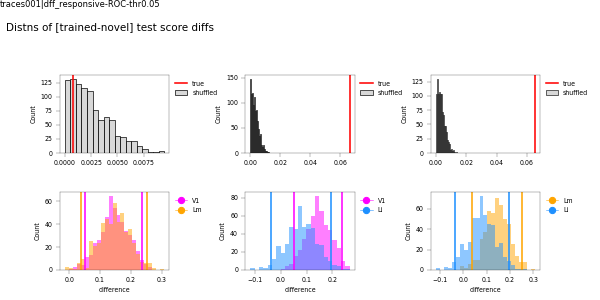

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 shuffle_test_trained-v-novel


In [234]:
n_shuff=1000
p_vals = []
metric='difference'
# v1='Lm'
# v2='Li'
v_combos = list(itertools.combinations(visual_areas, 2))

fig, axn = pl.subplots(2, len(v_combos), figsize=(8,4))

for ai, (v1, v2) in enumerate(v_combos):
    v_list = [v1, v2]
    a_ = all_vals[all_vals.visual_area==v1][metric]
    b_ = all_vals[all_vals.visual_area==v2][metric]
    true_ = abs(a_.mean() - b_.mean())

    combined_ = pd.concat([a_, b_], axis=0, ignore_index=True).values
    shuff_=[]
    for n in range(n_shuff):
        np.random.shuffle(combined_)
        i = np.mean(combined_[0:500])
        v = np.mean(combined_[500:])
        diff_s = abs(i-v)
        shuff_.append(diff_s)
    shuff = np.array(shuff_)
    pv_ = len(np.where(shuff>true_)[0])/n_shuff
    p_vals.append(pd.Series({'v1': v1, 'v2': v2, 'p_val': pv_}))
    
    ax=axn[0, ai]
    sns.histplot(shuff, color=[0.8]*3, ax=ax, label='shuffled')
    ax.axvline(x=true_, color='r', label='true')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

    ax=axn[1, ai]
    c1= area_colors[v1]
    c2 = c2=area_colors[v2]
    sns.histplot(x=metric, hue='visual_area', ax=ax,
                 data=all_vals[all_vals.visual_area.isin(v_list)], 
                 palette={v1:c1, v2: c2}, fill=True, edgecolor=None)
    c_lo, c_hi = hutils.get_empirical_ci(all_vals[all_vals.visual_area==v1][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)

    c_lo, c_hi = hutils.get_empirical_ci(all_vals[all_vals.visual_area==v2][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    leg_h = pplot.custom_legend_markers(colors=[c1, c2], labels=[v1, v2])
    ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.75, wspace=0.7, hspace=0.5)
fig.text(0.01, 0.9, "Distns of [trained-novel] test score diffs")

pplot.label_figure(fig, data_id)

figname = 'shuffle_test_trained-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)


In [200]:
pd.concat(p_vals, axis=1).T


,v1,v2,p_val
0,V1,Lm,0.823
1,V1,Li,0.0
2,Lm,Li,0.0


In [195]:
pg.multicomp(p_vals, alpha=0.05, method='bonf')

(array([False,  True,  True]), array([1., 0., 0.]))

In [205]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00'

## Check if NOVEL v TRAINED diff

In [124]:
# df_ = mean_df[(mean_df['n_cells']==max_ncells) 
#             & (mean_df['condition']=='data')].copy()
# df_.groupby(['visual_area', 'novel']).count()

# df_ = mean_df[(mean_df['n_cells']==max_ncells) 
#             & ~(mean_df['novel'])].copy().reset_index(drop=True)
# df_.groupby(['visual_area', 'condition']).count()

df_ = mean_df[(mean_df['n_cells']==96) 
            & (mean_df['condition']=='data')].copy().reset_index(drop=True)
df_.groupby(['visual_area', 'novel']).count()

condition  iteration  n_cells  fit_time  score_time  \
visual_area novel                                                        
Li          False        500        500      500       500         500   
            True         500        500      500       500         500   
Lm          False        500        500      500       500         500   
            True         500        500      500       500         500   
V1          False        500        500      500       500         500   
            True         500        500      500       500         500   

                   test_score  train_score  heldout_test_score    C  randi  \
visual_area novel                                                            
Li          False         500          500                 500  500    500   
            True          500          500                 500  500    500   
Lm          False         500          500                 500  500    500   
            True          500          500                 500  500    500   
V1          False         500          500                 500  500    500   
            True          500          500                 500  500    500   

                   train_transform  test_transform  n_trials  randi_cells  \
visual_area novel                                                           
Li          False              500             500       500          500   
            True               500             500       500          500   
Lm          False              500             500       500          500   
            True               500             500       500          500   
V1          False              500             500       500          500   
            True               500             500       500          500   

                   intact  overlap_thr  
visual_area novel                       
Li          False     500          500  
            True      500          500  
Lm          False     500          500  
            True      500          500  
V1          False     500          500  
            True      500          500

<IPython.core.display.Javascript object>


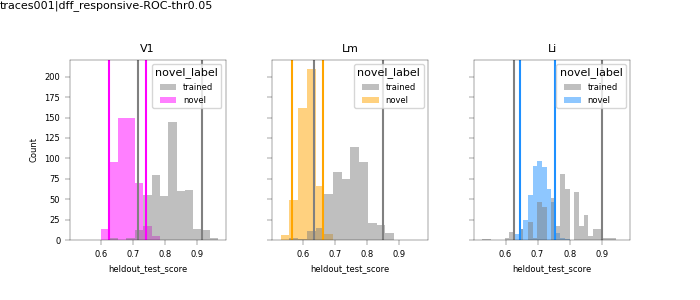

In [125]:
metric='heldout_test_score'
# c1='cornflowerblue'
# c2 = [0.8]*3
v1='novel'
v2='trained'
df_['novel_label'] = [v1 if v else v2 for v in df_['novel'].values]
fig, axn = pl.subplots(1,3, figsize=(7,3), sharex=True, sharey=True)

for va, vg in df_.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    c1 = area_colors[va]
    c2 = [0.5]*3
#     a_ = vg[(vg.novel)][metric]
#     b_ = vg[~(vg.novel)][metric]
#     true_ = b_.mean() - a_.mean()
#     combined_ = pd.concat([a_, b_], axis=0, ignore_index=True).values
#     shuff_=[]
#     for n in range(1000):
#         np.random.shuffle(combined_)
#         i = np.mean(combined_[0:500])
#         v = np.mean(combined_[500:])
#         ds_ = abs(i-v)
#         shuff_.append(ds_)
#     shuff = np.array(shuff_)
#     sns.histplot(shuff, color=[0.8]*3, ax=ax, label='shuffled')
#     ax.axvline(x=true_, color='r', label='true')
#     print(len(np.where(shuff>true_)[0])/2000.)
#     pl.subplots_adjust(bottom=0.2, right=0.8)

    sns.histplot(x='heldout_test_score', hue='novel_label', data=vg, ax=ax,
                palette={v1: c1, v2: c2}, fill=True, edgecolor=None)
#     ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

    c_lo, c_hi = hutils.get_empirical_ci(vg[vg.novel][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)

    c_lo, c_hi = hutils.get_empirical_ci(vg[~(vg.novel)][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    ax.set_title(va)
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.3)
pplot.label_figure(fig, data_id)

# figname = 'distns_95CI_test_trained-v-novel'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)


In [131]:
len(np.where(shuff<true_)[0])/1000.


1.667

In [357]:
import pingouin as pg

In [375]:
plotd = df_[['visual_area', 'novel', 'heldout_test_score', 'iteration']].copy().reset_index(drop=True)
plotd['subject'] = ['%s_%i' % (va, ni) for va, ni in plotd[['visual_area', 'iteration']].values]
plotd.head()

,visual_area,novel,heldout_test_score,iteration,subject
0,Li,False,0.825000,0,Li_0
1,Li,True,0.713158,0,Li_0
2,Li,False,0.900000,1,Li_1
3,Li,True,0.755263,1,Li_1
4,Li,False,0.650000,2,Li_2


In [372]:
from pingouin import mixed_anova, read_dataset
df = read_dataset('mixed_anova')
df

,Scores,Time,Group,Subject
0,5.971435,August,Control,0
1,4.309024,August,Control,1
2,6.932707,August,Control,2
3,5.187348,August,Control,3
4,4.779411,August,Control,4
...,...,...,...,...
175,6.176981,June,Meditation,55
176,8.523692,June,Meditation,56
177,6.522273,June,Meditation,57
178,4.990568,June,Meditation,58


In [378]:
pg.mixed_anova(data=plotd, dv='heldout_test_score', within='novel', 
              between='visual_area', subject='subject', correction=True)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,visual_area,2.954740,2,1497,1.477370,822.690953,9.019487e-242,0.52361,NaN
1,novel,11.500601,1,1497,11.500601,8041.647076,0.000000e+00,0.84306,1.0
2,Interaction,0.721420,2,1497,0.360710,252.221841,3.962799e-95,0.25204,NaN


<IPython.core.display.Javascript object>


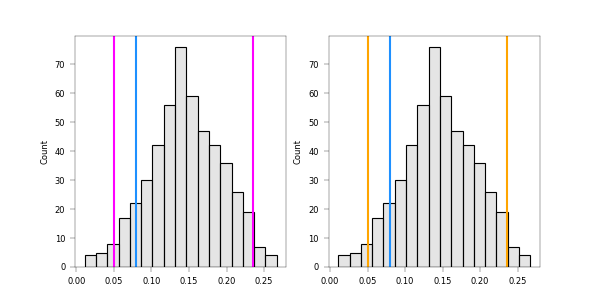

In [229]:
all_vals =  diffs[diffs.condition=='data']
li_vals = all_vals[all_vals.visual_area=='Li']['difference'].values
lm_vals = all_vals[all_vals.visual_area=='Lm']['difference'].values
v1_vals = all_vals[all_vals.visual_area=='V1']['difference'].values

fig, axn = pl.subplots(1,2, figsize=(6,3))
ax=axn[0]
compare_v = 'V1'
for ax, compare_v in zip(axn.flat, ['V1', 'Lm']):
    compare_vals = all_vals[all_vals.visual_area==compare_v]['difference'].values
    sns.histplot(v1_vals, color=[0.8]*3, alpha=0.5, ax=ax)
    c_lo, c_hi = hutils.get_empirical_ci(v1_vals, ci=0.95)
    ax.axvline(x=c_lo, color=area_colors[compare_v])
    ax.axvline(x=c_hi, color=area_colors[compare_v])

    # # sns.histplot(x='trained_minus_novel', data=plotd[plotd['rfs']=='matched'], ax=ax)
    mean_v = np.mean(li_vals)
    ax.axvline(x=mean_v, color=area_colors['Li'])

In [168]:
diffs[diffs.condition=='data'].groupby('visual_area').describe()

difference                                                    \
                 count      mean       std       min       25%       50%   
visual_area                                                                
Li               500.0  0.064928  0.056877 -0.093421  0.023684  0.068421   
Lm               500.0  0.065104  0.055064 -0.100862  0.028664  0.064080   
V1               500.0  0.140040  0.043500 -0.012356  0.113937  0.139655   

                                 
                  75%       max  
visual_area                      
Li           0.106579  0.198684  
Lm           0.101509  0.242816  
V1           0.169325  0.262356

## Split generalization score by TRAIN vs TEST

In [169]:
# results.loc[results['heldout_test_score']==0, 'heldout_test_score'] = 0.000000000001
metric='heldout_test_score'
drop_cols = ['fit_time', 'score_time', 'train_score', 'test_score']
cols = [c for c in iterdf.columns if c not in drop_cols]
data_df = iterdf[(iterdf.condition=='data')][cols].copy().reset_index(drop=True)

data_df['generalization'] = None
data_df['train_test_diff'] = None
for tr, g in data_df.groupby(['train_transform']):
    train_vals = g[g.train_transform==g.test_transform][metric].values
    for te, gg in g.groupby(['test_transform']):
        data_df.loc[gg.index, 'generalization']= gg[metric]/train_vals
        data_df.loc[gg.index, 'train_test_diff'] = tr-te
data_df['generalization'] = data_df['generalization'].astype(float)
data_df['train_test_abs'] = np.abs(data_df['train_test_diff']).astype(float)
data_df['train_test_diff'] = data_df['train_test_diff'].astype(float)

In [170]:
itergroup_cols = ['n_cells', 'visual_area', 'novel', 
                  'test_transform', 'train_test_diff', 'iteration']
datameans_per_iter = data_df.groupby(itergroup_cols).mean().reset_index()
# means_per_iter

In [171]:
for tr, g in data_df[(data_df.n_cells==max_ncells)].groupby(['train_transform']):
    train_vals = g[g.train_transform==g.test_transform]['heldout_test_score'].values
    print(tr, train_vals.min(), train_vals.max()) #dropna().shape)

10.0 0.16666666666666666 1.0
20.0 0.25 1.0
30.0 0.25 1.0
40.0 0.25 1.0
50.0 0.375 1.0


In [172]:
datameans_per_iter.groupby(['visual_area', 'n_cells', 
                            'train_transform', 'test_transform']).count()

novel  train_test_diff  \
visual_area n_cells train_transform test_transform                           
Li          1       10.0            10.0              500              500   
                                    20.0              500              500   
                                    30.0              500              500   
                                    40.0              500              500   
                                    50.0              500              500   
...                                                   ...              ...   
V1          96      50.0            10.0              500              500   
                                    20.0              500              500   
                                    30.0              500              500   
                                    40.0              500              500   
                                    50.0              500              500   

                                                    iteration  \
visual_area n_cells train_transform test_transform              
Li          1       10.0            10.0                  500   
                                    20.0                  500   
                                    30.0                  500   
                                    40.0                  500   
                                    50.0                  500   
...                                                       ...   
V1          96      50.0            10.0                  500   
                                    20.0                  500   
                                    30.0                  500   
                                    40.0                  500   
                                    50.0                  500   

                                                    heldout_test_score    C  \
visual_area n_cells train_transform test_transform                            
Li          1       10.0            10.0                           500  500   
                                    20.0                           500  500   
                                    30.0                           500  500   
                                    40.0                           500  500   
                                    50.0                           500  500   
...                                                                ...  ...   
V1          96      50.0            10.0                           500  500   
                                    20.0                           500  500   
                                    30.0                           500  500   
                                    40.0                           500  500   
                                    50.0                           500  500   

                                                    randi  n_trials  \
visual_area n_cells train_transform test_transform                    
Li          1       10.0            10.0              500       500   
                                    20.0              500       500   
                                    30.0              500       500   
                                    40.0              500       500   
                                    50.0              500       500   
...                                                   ...       ...   
V1          96      50.0            10.0              500       500   
                                    20.0              500       500   
                                    30.0              500       500   
                                    40.0              500       500   
                                    50.0              500       500   

                                                    randi_cells  intact  \
visual_area n_cells train_transform test_transform                        
Li          1       10.0            10.0                    500     500   
              

visual_area
Li      inf
Lm      inf
V1    0.956
Name: generalization, dtype: float64
visual_area
Li      NaN
Lm      NaN
V1    0.303
Name: generalization, dtype: float64


<IPython.core.display.Javascript object>


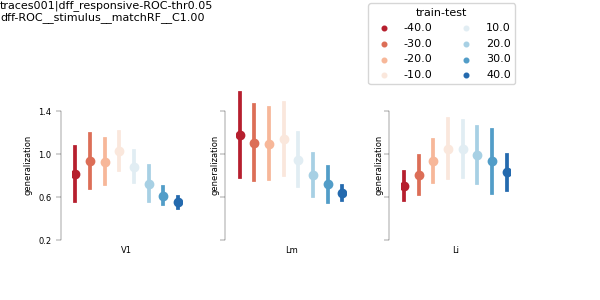

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls generalization_split_traintest__dff-ROC__stimulus__matchRF__C1.00


In [173]:
metric='generalization'
size_metric='train_test_diff'
multi_comp_test='fdr_bh'

curr_ncells=max_ncells

print(datameans_per_iter.groupby(['visual_area'])[metric].mean().round(3))
print(datameans_per_iter.groupby(['visual_area'])[metric].std().round(3))

plotd = datameans_per_iter[(datameans_per_iter.novel) 
                         & (datameans_per_iter['n_cells']==curr_ncells)].copy()

diff_palette = 'Greys' if size_metric=='train_test_abs' else 'RdBu'

#fig, axn = pl.subplots(1,2, figsize=(6.5,3), dpi=dpi, sharex=True, sharey=False)
fig, axn = pl.subplots(1, 3, figsize=(6,3), sharex=True,sharey=True)

# PLOT 2
for va, vg in plotd.groupby(['visual_area']):
    ax = axn[visual_areas.index(va)]
    sns.pointplot(x=size_metric, y=metric, hue=size_metric, data=vg, ax=ax, 
             palette=diff_palette, scale=0.8, 
              dodge=0.5, join=False, ci='sd', markers='o')
    ax.legend_.remove()
    ax.set_yticks(np.linspace(0.2, 1.4, 4))
    ax.set_ylim([0.2, 1.6])    
    ax.set_xlabel(va)
axn[-1].legend(bbox_to_anchor=(1.1, 1.), loc='lower right', title='train-test', markerscale=0.5, fontsize=8,
         ncol=2)

pl.tight_layout()
pl.subplots_adjust(left=0.12, right=0.85, wspace=0.5, top=0.7, bottom=0.2)

sns.despine(bottom=True, offset=8, trim=True)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xticks([])

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
figname='generalization_split_traintest__%s' % aggr_id #% (dset_str, shuffle_str, errstr)
#figname='genratio_meanbyiter_split_traintransform__%s_%s_%s2' % (dset_str, shuffle_str, errstr)

pl.savefig(os.path.join(curr_dst_dir,  '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


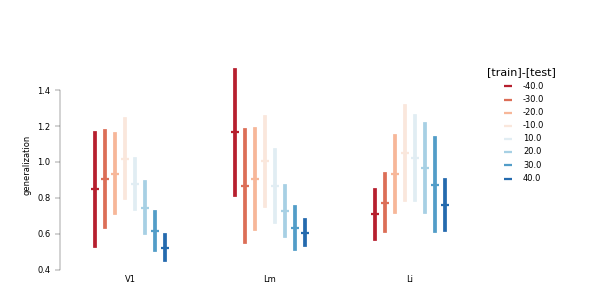

In [112]:
#fig, axn = pl.subplots(1,2, figsize=(6.5,3), dpi=dpi, sharex=True, sharey=False)
fig, ax = pl.subplots(figsize=(6,3))

# PLOT 2

sns.pointplot(x='visual_area', y=metric, data=plotd, ax=ax, 
           hue=size_metric, order=visual_areas, palette=diff_palette, scale=0.8, 
              dodge=0.5, join=False, ci='sd', markers='_')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False, 
         title='[train]-[test]')
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.8)
sns.despine(bottom=True, trim=True)


In [53]:
import statsmodels.api as sm

In [54]:
iterdf.

SyntaxError: invalid syntax (<ipython-input-54-f61dbf0a6fe9>, line 1)

In [ ]:
if analysis_type=='by_fov':
    bw_cond_colors = dict((k, [0.7]*3) for k in ['data', 'shuffled'])
    cond_colors = {'data': 'cornflowerblue', 'shuffled': [0.3]*3}


    fig, axn = pl.subplots(1,2, figsize=(6.5, 3), sharex=True, sharey=True)
    for ai, (is_intact, df) in enumerate(DF.groupby('intact')):
        ax=axn[ai]
        corr_str = 'Intact' if is_intact else 'No corrs.'
        ax.set_title(corr_str)
        sns.barplot(x='visual_area', y=metric, data=df, ax=ax,
                hue='condition', order=visual_areas, ci=None, palette=bw_cond_colors)
        sns.stripplot(x='visual_area', y=metric, data=df, ax=ax,
                hue='condition', order=visual_areas, palette=cond_colors,
                jitter=False, dodge=True, s=4)

        ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
        ax.legend_.remove()
    axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
    pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.85,
                      wspace=0.3)

    pplot.label_figure(fig, aggr_id)
    figname = 'intact_vs_indep'
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [167]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov'

<IPython.core.display.Javascript object>


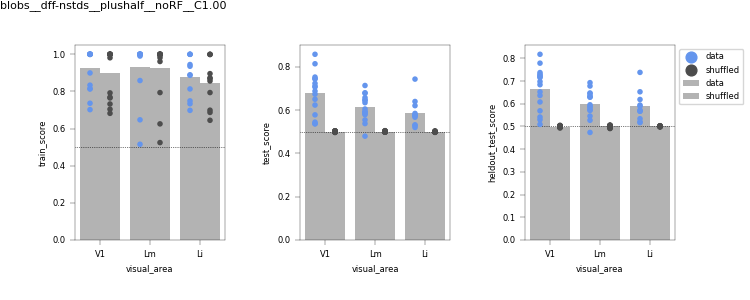

In [168]:
bw_cond_colors = dict((k, [0.7]*3) for k in ['data', 'shuffled'])
cond_colors = {'data': 'cornflowerblue', 'shuffled': [0.3]*3}

metric_list = ['train_score', 'test_score', 'heldout_test_score']

fig, axn = pl.subplots(1, len(metric_list), figsize=(2.5*len(metric_list), 3))
for ai, metric in enumerate(metric_list):
    ax=axn[ai]
    sns.barplot(x='visual_area', y=metric, data=df, ax=ax,
            hue='condition', order=visual_areas, ci=None, palette=bw_cond_colors)
    sns.stripplot(x='visual_area', y=metric, data=df, ax=ax,
            hue='condition', order=visual_areas, palette=cond_colors,
            jitter=False, dodge=True, s=4)
    
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.legend_.remove()
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.85,
                  wspace=0.5)

pplot.label_figure(fig, aggr_id)
figname = 'aggr_performance_metrics'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [183]:
DF

,visual_area,datakey,condition,novel,train_transform,test_transform,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,n_trials,iteration,n_cells,intact
0,Li,20190422_JC076_fov1,data,False,10_20_30_40,10_20_30_40,0.011768,0.000475,0.526641,0.886592,0.011687,0.001365,0.016860,0.532917,1.0,4768.29,240.0,49.5,68.0,True
1,Li,20190422_JC076_fov1,data,False,10_20_30_50,10_20_30_50,0.011565,0.000462,0.536306,0.892078,0.009614,-0.001699,0.013870,0.537917,1.0,5212.13,240.0,49.5,68.0,True
2,Li,20190422_JC076_fov1,data,False,10_20_40_50,10_20_40_50,0.011347,0.000465,0.538179,0.895239,0.012811,0.002960,0.018483,0.543958,1.0,5011.99,240.0,49.5,68.0,True
3,Li,20190422_JC076_fov1,data,False,10_30_40_50,10_30_40_50,0.014093,0.000477,0.512409,0.872984,0.010969,0.000264,0.015826,0.523542,1.0,4847.80,240.0,49.5,68.0,True
4,Li,20190422_JC076_fov1,data,False,20_30_40_50,20_30_40_50,0.010543,0.000458,0.544619,0.900372,0.016351,0.008292,0.023590,0.552708,1.0,4803.09,240.0,49.5,68.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,V1,20191006_JC110_fov1,shuffled,False,10_20_30_40,10_20_30_40,0.005513,0.000721,0.496537,1.000000,0.009511,-0.000313,0.013722,0.493585,1.0,5074.57,264.0,49.5,221.0,True
626,V1,20191006_JC110_fov1,shuffled,False,10_20_30_50,10_20_30_50,0.005505,0.000725,0.507712,1.000000,0.012291,0.003762,0.017732,0.476226,1.0,5191.18,264.0,49.5,221.0,True
627,V1,20191006_JC110_fov1,shuffled,False,10_20_40_50,10_20_40_50,0.005547,0.000745,0.502377,1.000000,0.009419,-0.000424,0.013588,0.503962,1.0,5052.93,264.0,49.5,221.0,True
628,V1,20191006_JC110_fov1,shuffled,False,10_30_40_50,10_30_40_50,0.005608,0.000740,0.491905,1.000000,0.011515,0.002673,0.016613,0.510189,1.0,4996.48,264.0,49.5,221.0,True


<IPython.core.display.Javascript object>


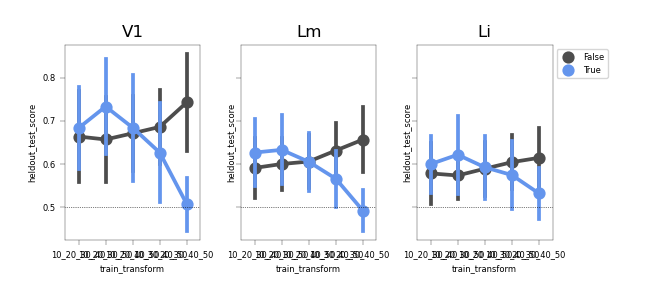

In [206]:
plotd = DF[DF.intact].copy()

keys = [True, False]
bw_cond_colors = dict((k, [0.7]*3) for k in keys)
#cond_colors = {'data': 'cornflowerblue', 'shuffled': [0.3]*3}
cond_colors = {keys[0]: 'cornflowerblue', keys[1]: [0.3]*3}

metric = 'heldout_test_score'
fig, axn = pl.subplots(1,3, figsize=(6.5, 3), sharex=True, sharey=True)
for vi, (va, df) in enumerate(DF.groupby('visual_area')):
    ai = visual_areas.index(va)
    ax=axn[ai]
    ax.set_title(va)
    sns.pointplot(x='train_transform', y=metric, data=df, ax=ax,
            hue='novel', ci='sd', palette=cond_colors)
#     sns.stripplot(x='visual_area', y=metric, data=df, ax=ax,
#             hue='condition', order=visual_areas, palette=cond_colors,
#             jitter=False, dodge=True, s=4)
    
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.legend_.remove()
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.85,
                  wspace=0.3)

# pplot.label_figure(fig, aggr_id)
# figname = 'intact_vs_indep'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))